In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy import units as u

In [3]:
import pylab as pl
pl.rcParams['figure.figsize'] = (20,8)

In [4]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube
import warnings
import spectral_cube
warnings.filterwarnings(action='ignore', category=spectral_cube.utils.StokesWarning)
warnings.filterwarnings(action='ignore', category=spectral_cube.utils.BeamWarning)

In [5]:
import os
os.chdir("/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/imaging_results")

In [6]:
ls -lhrtd W51-E_B6_clean_mask.mask

drwxr-xr-x 3 aginsbur observer 33K Mar 13 12:09 W51-E_B6_clean_mask.mask/


This custom mask was produced based on the first iteration of cleaning.  The rectangular structures suggest that the thresholds in the individual regions were too deep.

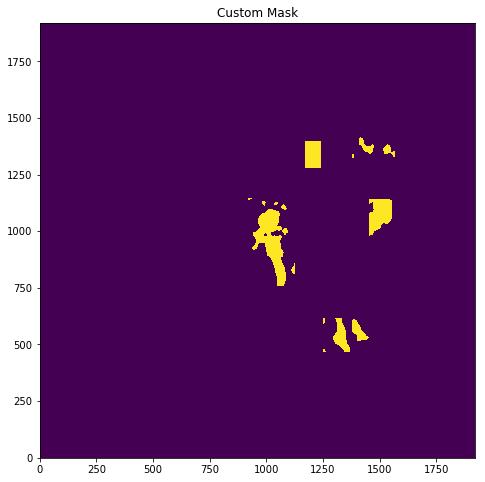

In [7]:
mask = SpectralCube.read('W51-E_B6_clean_mask.mask', format='casa_image')[0]
pl.imshow(mask.value, origin='lower', interpolation='none')
pl.title("Custom Mask")

In [8]:
imgs_dirty_b6, cubes_dirty_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_dirty')
imgs_before_b6, cubes_before_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0')
imgs_after_b6, cubes_after_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal1')
imgs_after2_b6, cubes_after2_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal2')

In the images below, the white contours show the mask.

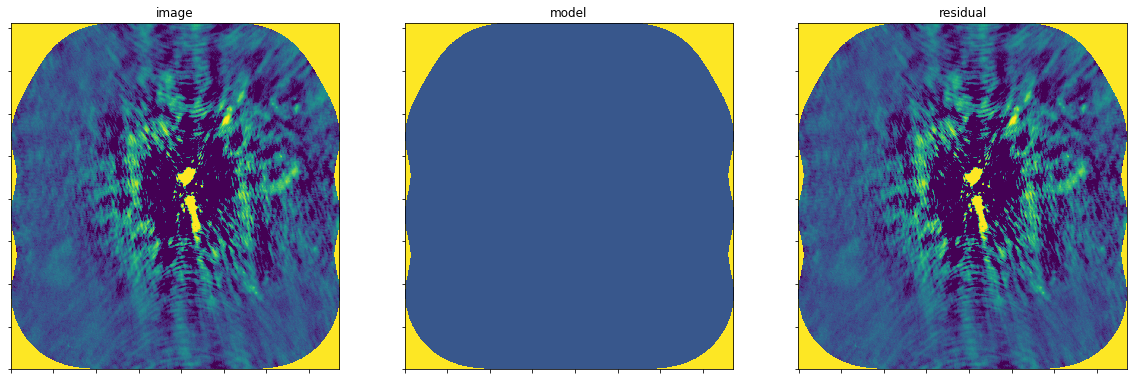

In [9]:
show(imgs_dirty_b6, vmin=-0.001, vmax=0.01)

Contrasting between the following two panels shows major problems.  The "before_b6" panel shows the cleaned image with no self-calibration. The most notable feature is the extended structure around the mask: the model includes a great deal of flux beyond the mask boundaries, which is not particularly desirable and suggests that we should reduce the maximum angular scale in the multiscale clean.

The most glaring difference between the first and second rows is the lack of extended structure in the second set of images, which were self-calibrated.  Note the diffuse region in the lower-left disappears.  This loss, and the general loss of flux, most likely indicates that bad self-calibration solutions were applied to the data and washed out some real emission as a result.  However, see the zoom-in panel discussion below.

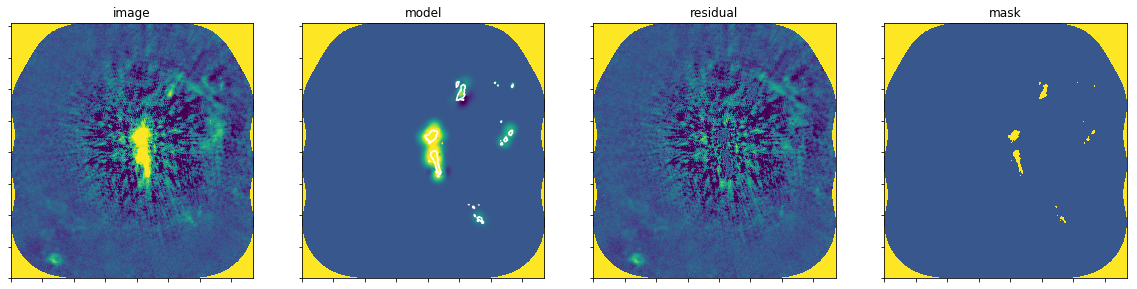

In [10]:
show(imgs_before_b6, vmin=-0.001, vmax=0.01)

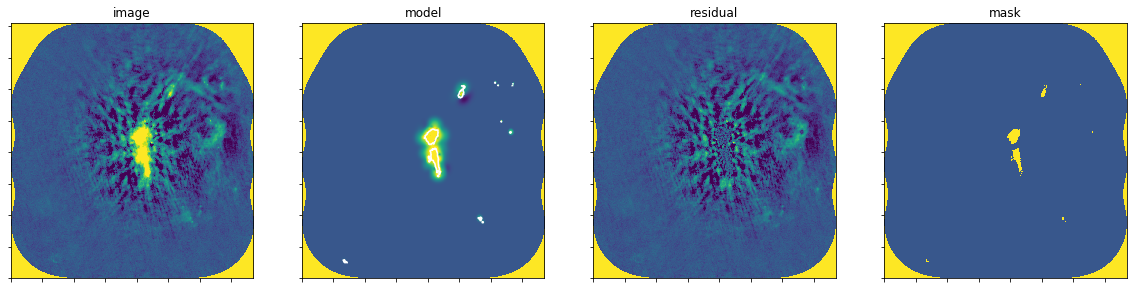

In [11]:
show(imgs_after_b6, vmin=-0.001, vmax=0.01)

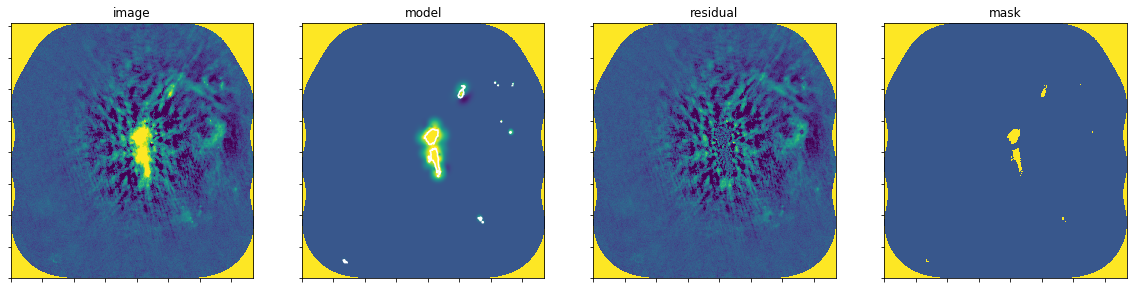

In [12]:
show(imgs_after2_b6, vmin=-0.001, vmax=0.01)

### Zoom-in panel discussion

These are the same images as shown above, but now zoomed in on the central regions with a higher peak intensity.

The most notable feature is the sharpening of the image from the pre- to post-selfcal images.  Selfcal is substantially increasing the signal-to-noise ratio in this region.  So, it appears that selfcal _was_ successful for the inner pointing, just not for the outer pointings.

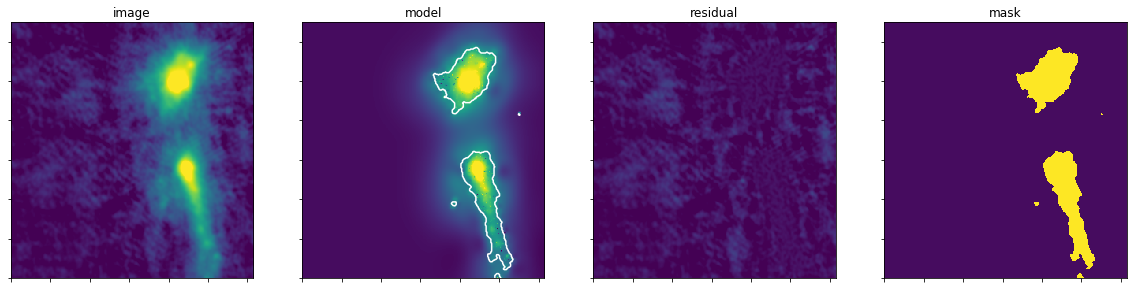

In [13]:
show(imgs_before_b6, vmin=-0.001, vmax=0.1, zoom=0.2)

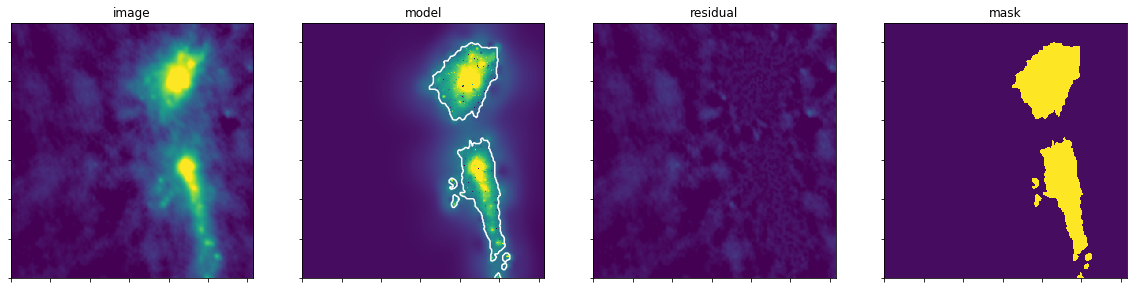

In [14]:
show(imgs_after_b6, vmin=-0.001, vmax=0.1, zoom=0.2)

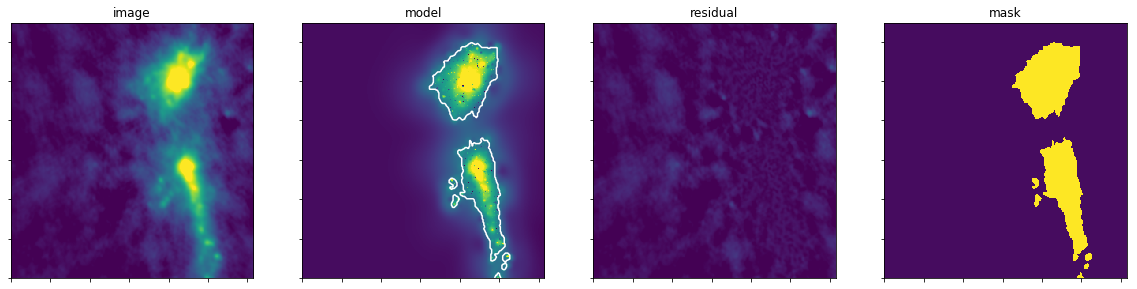

In [15]:
show(imgs_after2_b6, vmin=-0.001, vmax=0.1, zoom=0.2)

## Measurements of the peak-to-RMS ratio and RMS in each stage:

In [16]:
for imgs in (imgs_before_b6, imgs_after_b6, imgs_after2_b6):
    rms = np.nanstd(imgs['residual'].value*u.Jy/u.beam) # residual has bad header units
    peak = np.nanmax(imgs['image'].quantity)
    print(f"peak/rms = {peak/rms:0.1f}, peak={peak:0.3f}, rms={rms:0.5f}")

peak/rms = 432.1, peak=0.272 Jy / beam, rms=0.00063 Jy / beam
peak/rms = 874.2, peak=0.444 Jy / beam, rms=0.00051 Jy / beam
peak/rms = 870.1, peak=0.444 Jy / beam, rms=0.00051 Jy / beam


The RMS is shrinking overall and the peak is rising, which is good.  However, the loss of flux shown in the main images suggests that this result isn't good enough.

For our records, we want to know what imaging parameters were used for these images:

In [17]:
import casatools
ia = casatools.image()
ia.open('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0.image.tt0')
print(ia.history())
ia.close()

['minpsffraction: 0.05', 'lownoisethreshold: 1.5', 'phasecenter: ICRS 290.934083333deg 14.5082118527deg', 'outlierfile: ', 'scan: ', 'calcres: True', 'minpercentchange: -1.0', 'timerange: ', 'spw: ', 'dogrowprune: True', 'vis: ', 'imagename: ', 'usepointing: False', 'rotatepastep: 360.0', 'vptable: ', 'threshold: 0.0', 'pbmask: 0.0', 'sidelobethreshold: 3.0', 'aterm: True', 'imsize: [1920, 1920]', 'scales: []', 'robust: 0.5', 'projection: SIN', 'antenna: ', 'start: ', 'parallel: False', 'npixels: 0', 'conjbeams: False', 'mosweight: True', 'negativethreshold: 0.0', "cell: ['1arcsec']", 'field: W51-E', 'growiterations: 75', 'outframe: LSRK', 'wbawp: True', 'restfreq: []', 'cutthreshold: 0.01', 'gridder: standard', 'interpolation: linear', 'cycleniter: -1', 'niter: 0', 'psterm: False', 'noisethreshold: 5.0', 'datacolumn: corrected', 'nsigma: 0.0', 'savemodel: none', 'wprojplanes: 1', 'reffreq: ', 'restoration: True', 'intent: ', 'gain: 0.1', 'uvrange: ', 'cyclefactor: 1.0', 'startmodel: '

True

However, this shows that `tclean.parameters` does not actually record what was last run: the scales listed are incorrect.